In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler

spark = SparkSession.builder.appName("KMeansClustering").getOrCreate()

In [2]:
batch_1_path = '../dataset/batch-dataset/batch_1.csv'

data = spark.read.csv(batch_1_path, header=True)

In [3]:
data.show()

+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+------------------+--------------------+----------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|  content_duration| published_timestamp|         subject|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+------------------+--------------------+----------------+
|  1070968|Ultimate Investme...|https://www.udemy...|   True|  200|           2147|         23|          51|        All Levels|               1.5|2017-01-18T20:58:58Z|Business Finance|
|  1113822|Complete GST Cour...|https://www.udemy...|   True|   75|           2792|        923|         274|        All Levels|              39.0|2017-03-09T16:34:20Z|Business Finance|
|  1006314|Financial Modelin...|https://www.udemy...|   True|   45|        

In [4]:
data.printSchema()

root
 |-- course_id: string (nullable = true)
 |-- course_title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- is_paid: string (nullable = true)
 |-- price: string (nullable = true)
 |-- num_subscribers: string (nullable = true)
 |-- num_reviews: string (nullable = true)
 |-- num_lectures: string (nullable = true)
 |-- level: string (nullable = true)
 |-- content_duration: string (nullable = true)
 |-- published_timestamp: string (nullable = true)
 |-- subject: string (nullable = true)



In [5]:
# Konversi kolom menjadi tipe df numerik
data = data.withColumn("num_subscribers", col("num_subscribers").cast("float"))
data = data.withColumn("num_reviews", col("num_reviews").cast("float"))
data = data.withColumn("num_lectures", col("num_lectures").cast("float"))
data = data.withColumn("content_duration", col("content_duration").cast("float"))

# Hapus baris dengan nilai null di kolom yang dipilih
data = data.dropna()

# Hapus kolom 'features_unscaled' dan 'features' jika sudah ada
if "features_unscaled" in data.columns:
    data = data.drop("features_unscaled")
if "features" in data.columns:
    data = data.drop("features")

# Gabungkan fitur menjadi vektor tunggal
assembler = VectorAssembler(inputCols=["num_subscribers", "num_reviews", "num_lectures", "content_duration"], 
                            outputCol="features_unscaled")
data = assembler.transform(data)

data.show()

+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+--------------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration| published_timestamp|         subject|   features_unscaled|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+--------------------+
|  1070968|Ultimate Investme...|https://www.udemy...|   True|  200|         2147.0|       23.0|        51.0|        All Levels|             1.5|2017-01-18T20:58:58Z|Business Finance|[2147.0,23.0,51.0...|
|  1113822|Complete GST Cour...|https://www.udemy...|   True|   75|         2792.0|      923.0|       274.0|        All Levels|            39.0|2017-03-09T16:34:20Z|Business Finance|[2

In [6]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# Tampilkan hanya kolom 'features_unscaled' dan 'features'
data.select("features_unscaled", "features").show()

+--------------------+--------------------+
|   features_unscaled|            features|
+--------------------+--------------------+
|[2147.0,23.0,51.0...|[0.54830081482732...|
|[2792.0,923.0,274...|[0.71302090125659...|
|[2174.0,74.0,51.0...|[0.55519607425925...|
|[2451.0,11.0,36.0...|[0.62593632843119...|
|[1276.0,45.0,26.0...|[0.32586485315308...|
|[9221.0,138.0,25....|[2.35485878599105...|
|[1540.0,178.0,26....|[0.39328516759854...|
|[2917.0,148.0,23....|[0.74494339862660...|
|[5172.0,34.0,38.0...|[1.32082525118162...|
|[827.0,14.0,15.0,...|[0.21119924260000...|
|[4284.0,93.0,76.0...|[1.09404782986505...|
|[1380.0,42.0,17.0...|[0.35242437096493...|
|[3607.0,21.0,19.0...|[0.92115558410907...|
|[4061.0,52.0,16.0...|[1.03709809455695...|
|[294.0,19.0,42.0,...|[0.07508171381426...|
|[2276.0,106.0,19....|[0.58124483211318...|
|[4919.0,79.0,16.0...|[1.25621411650471...|
|[2666.0,115.0,52....|[0.68084302390761...|
|[5354.0,24.0,23.0...|[1.36730440735236...|
|[8095.0,249.0,12....|[2.0673009

In [7]:
data.select("features").rdd.map(lambda row: len(row["features"])).distinct().collect()

[4]

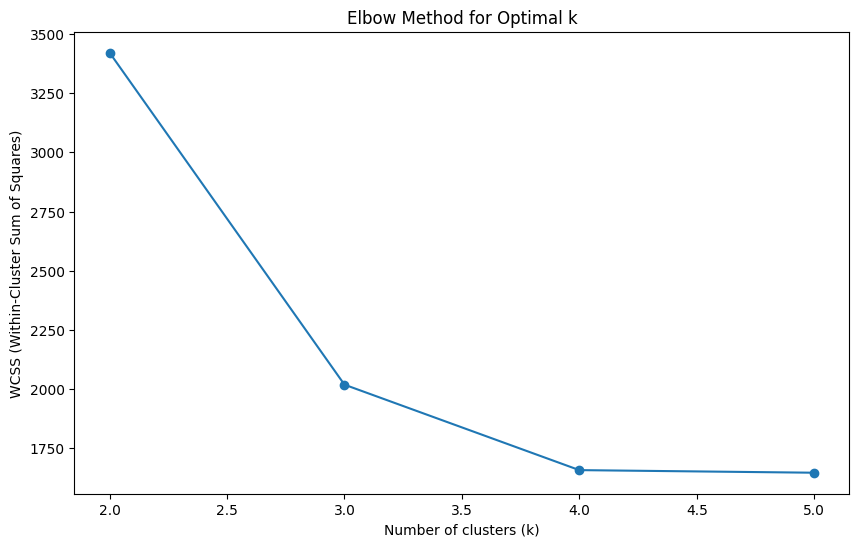

In [8]:
# Menyimpan nilai WCSS untuk berbagai k
wcss = []

# Loop untuk berbagai nilai k dari 2 hingga 5
for k in range(2, 6):
    kmeans = KMeans(featuresCol="features", k=k, seed=1)
    model = kmeans.fit(data)
    
    # Menghitung WCSS (dalam PySpark, ini disebut sebagai training cost)
    wcss.append(model.summary.trainingCost)

# Visualisasi dengan Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 6), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

In [9]:
# Fungsi untuk mencari nilai k optimal berdasarkan Silhouette Score
def find_optimal_k(data, max_k=10):
    silhouette_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(featuresCol="features", k=k, seed=1, maxIter=100, initSteps=10)
        model = kmeans.fit(data)
        predictions = model.transform(data)
        
        evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
        silhouette = evaluator.evaluate(predictions)
        silhouette_scores.append((k, silhouette))
        print(f"k: {k}, Silhouette Score: {silhouette}")
    
    # Menemukan nilai k dengan skor Silhouette terbaik
    best_k = max(silhouette_scores, key=lambda x: x[1])[0]
    print(f"\nOptimal k berdasarkan Silhouette Score adalah: {best_k}")
    
    return best_k, silhouette_scores

# Cari nilai k optimal (misalnya dengan max_k=5)
best_k, silhouette_scores = find_optimal_k(data, max_k=5)

# Setelah menemukan k optimal, latih model K-Means dengan k terbaik
kmeans = KMeans(featuresCol="features", k=best_k, seed=1, maxIter=100, initSteps=10)
model = kmeans.fit(data)

# Mendapatkan prediksi kluster dan menambahkan kolom 'prediction' ke DataFrame
data = model.transform(data)

# Evaluasi akhir dengan Silhouette Score untuk memastikan kualitas klustering
evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(data)
print(f"\nSilhouette Score untuk model dengan k={best_k}: {silhouette}")

# Menghitung rata-rata dari setiap fitur dalam setiap kluster
data.groupBy("prediction").avg("num_subscribers", "num_reviews", "num_lectures", "content_duration").show()


k: 2, Silhouette Score: 0.9337073605923674
k: 3, Silhouette Score: 0.9532238143366469
k: 4, Silhouette Score: 0.805532584239518
k: 5, Silhouette Score: 0.8733462117308266

Optimal k berdasarkan Silhouette Score adalah: 3

Silhouette Score untuk model dengan k=3: 0.9532238143366469
+----------+--------------------+-----------------+-----------------+---------------------+
|prediction|avg(num_subscribers)| avg(num_reviews)|avg(num_lectures)|avg(content_duration)|
+----------+--------------------+-----------------+-----------------+---------------------+
|         1|            35467.75|          2306.75|             55.5|               4.5625|
|         2|  1323.6801724137931|46.92672413793103|27.20258620689655|   2.8946839082215368|
|         0|             1967.04|           118.36|            268.2|                33.78|
+----------+--------------------+-----------------+-----------------+---------------------+



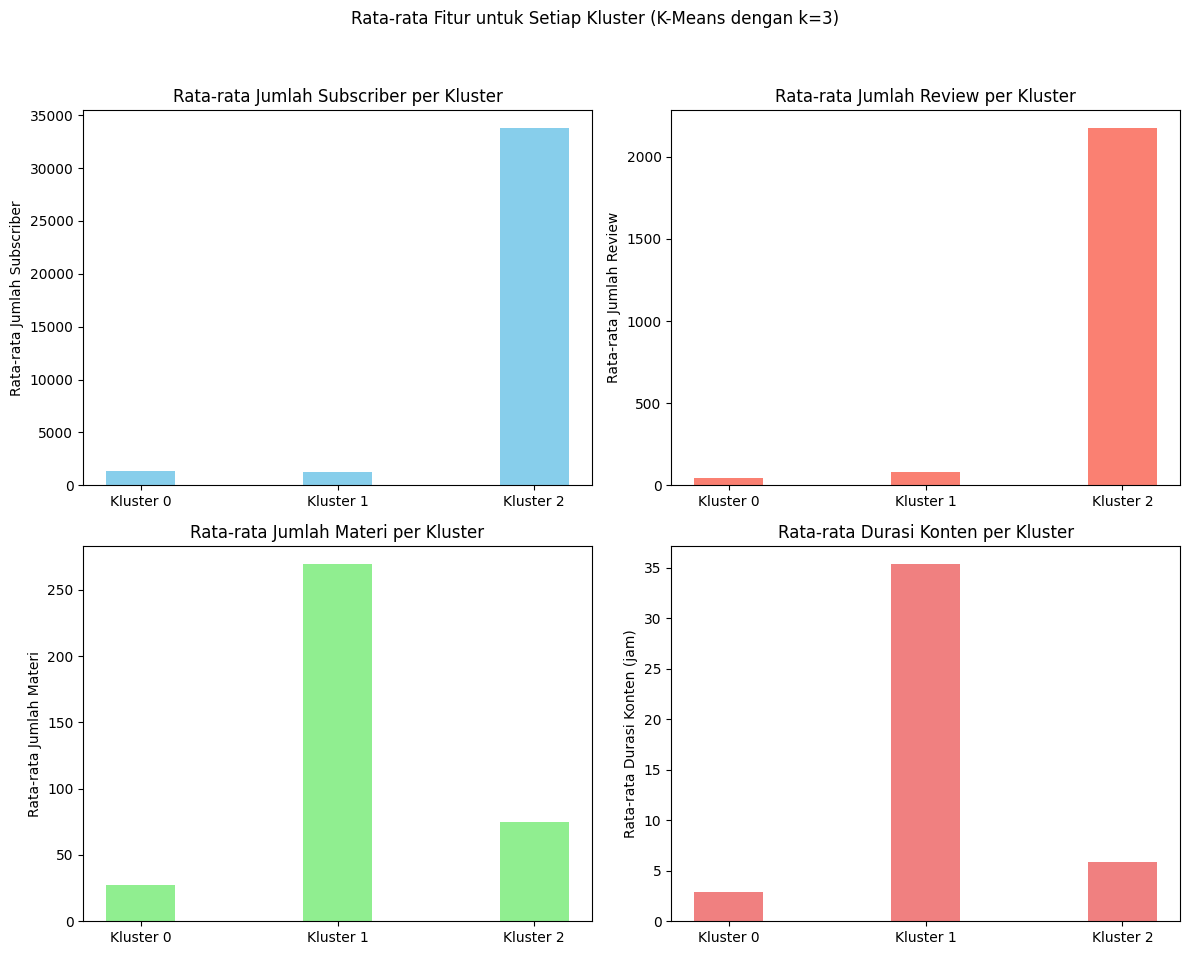

In [10]:
# Data hasil rata-rata dari setiap fitur dalam setiap kluster untuk k=3
cluster_labels = ["Kluster 0", "Kluster 1", "Kluster 2"]
avg_num_subscribers = [1324.68, 1288.23, 33770.78]
avg_num_reviews = [45.70, 82.14, 2174.11]
avg_num_lectures = [27.49, 269.32, 74.56]
avg_content_duration = [2.89, 35.36, 5.83]

# Mengatur lebar bar
bar_width = 0.35
index = np.arange(len(cluster_labels))

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Rata-rata Fitur untuk Setiap Kluster (K-Means dengan k=3)")

# Rata-rata 'num_subscribers'
axs[0, 0].bar(index, avg_num_subscribers, bar_width, color='skyblue')
axs[0, 0].set_xticks(index)
axs[0, 0].set_xticklabels(cluster_labels)
axs[0, 0].set_title("Rata-rata Jumlah Subscriber per Kluster")
axs[0, 0].set_ylabel("Rata-rata Jumlah Subscriber")

# Rata-rata 'num_reviews'
axs[0, 1].bar(index, avg_num_reviews, bar_width, color='salmon')
axs[0, 1].set_xticks(index)
axs[0, 1].set_xticklabels(cluster_labels)
axs[0, 1].set_title("Rata-rata Jumlah Review per Kluster")
axs[0, 1].set_ylabel("Rata-rata Jumlah Review")

# Rata-rata 'num_lectures'
axs[1, 0].bar(index, avg_num_lectures, bar_width, color='lightgreen')
axs[1, 0].set_xticks(index)
axs[1, 0].set_xticklabels(cluster_labels)
axs[1, 0].set_title("Rata-rata Jumlah Materi per Kluster")
axs[1, 0].set_ylabel("Rata-rata Jumlah Materi")

# Rata-rata 'content_duration'
axs[1, 1].bar(index, avg_content_duration, bar_width, color='lightcoral')
axs[1, 1].set_xticks(index)
axs[1, 1].set_xticklabels(cluster_labels)
axs[1, 1].set_title("Rata-rata Durasi Konten per Kluster")
axs[1, 1].set_ylabel("Rata-rata Durasi Konten (jam)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
model.save("spark_kmeans_model_a")

print("Model saved to spark_kmeans_model_a")

Model saved to spark_kmeans_model_a
